In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Professor names
professor_names = ['김유섭', '김은주', '이정근', '양은샘', '신미영', '김선정']

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set a seed value
SEED = 42
set_seed(SEED)

In [3]:
!sudo apt-get -q install -y fonts-noto-cjk
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.font_manager as fm

fm.fontManager.addfont('/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
sns.set(font='Noto Sans CJK JP', font_scale=.8)

Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 2s (30.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-noto-cjk.
(

In [4]:
df = pd.read_csv('merged_reviews_by_professor.csv', encoding='utf-8-sig')
df.head()

,professor,review
0,김유섭,실습 위주로 수업하는데 정말 좋어요 다음에고 듣고 싶어요
1,김유섭,매우 좋은 수업이긴하지만 공부할때 답안지가 없어서 친구와 같이 공부하는걸 선호합니디...
2,김유섭,2주에 한 번씩 쪽지시험있어서 공부 미리 할 수 있고 교재에 나오는 예제 문제 풀어...
3,김유섭,비대면이라 강의는 빠르게 듣고 어려운 부분만 집중적으로 다시 들을 수 있어서 좋았음...
4,김유섭,화 목을 신입생이랑 기존재학생으로 나누어서 수업해서그런지 진도 꿑까지 못빼서 아쉬웠...


### Generate embeddings

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased')

df['review_embedding'] = df['review'].apply(lambda x: model.encode(x))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

# EDA

### Display basic information


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   professor         1362 non-null   object
 1   review            1362 non-null   object
 2   review_embedding  1362 non-null   object
dtypes: object(3)
memory usage: 32.1+ KB


### Analyze review length

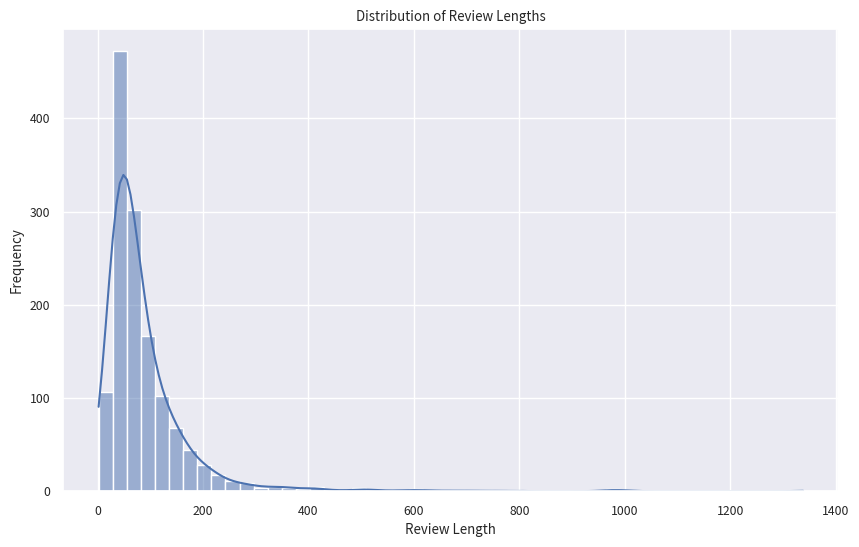

In [7]:
df['review_length'] = df['review'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df['review'].str.len(), bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Review Length')

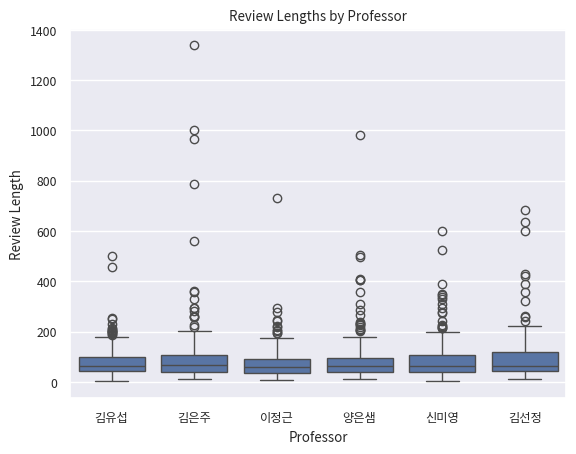

In [8]:
sns.boxplot(x='professor', y='review_length', data=df)
plt.title('Review Lengths by Professor')
plt.xlabel('Professor')
plt.ylabel('Review Length')

### Analyze word frequency

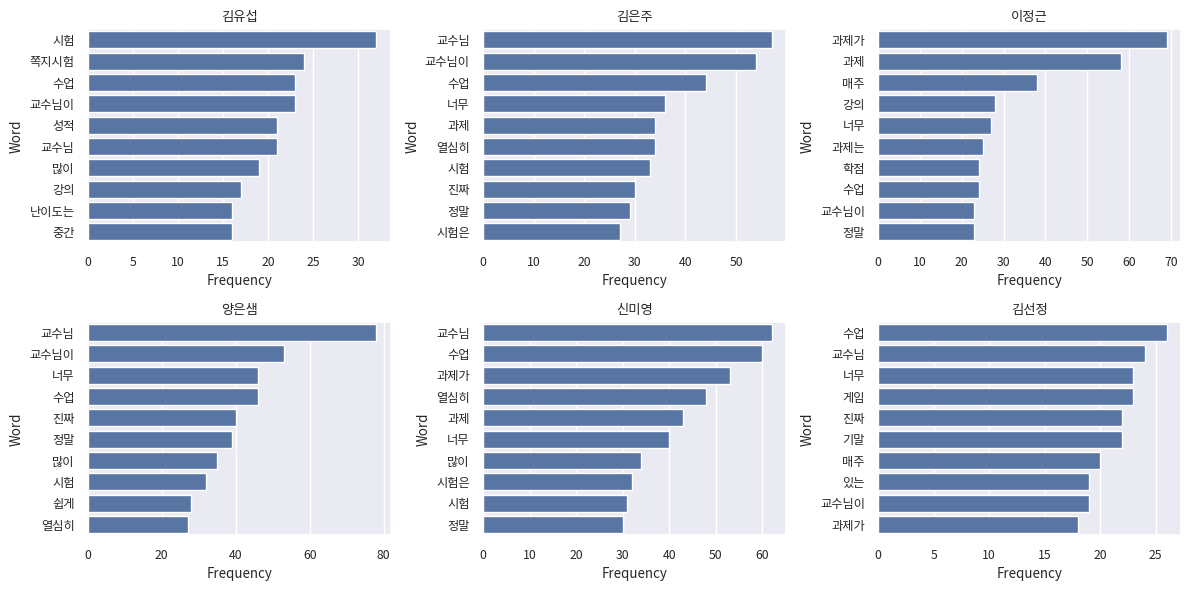

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(12, 6))

for i, professor in enumerate(professor_names):
    professor_df = df[df['professor'] == professor]
    all_reviews = ' '.join(professor_df['review'])

    all_reviews.strip()

    vectorizer = CountVectorizer(max_features=1000)
    X = vectorizer.fit_transform([all_reviews])

    frequency = np.sum(X.toarray(), axis=0)
    words = vectorizer.get_feature_names_out()

    word_frequencies = pd.DataFrame({'word': words, 'frequency': frequency})
    word_frequencies = word_frequencies.sort_values(by='frequency', ascending=False)

    plt.subplot(2, 3, i + 1)
    sns.barplot(x='frequency', y='word', data=word_frequencies.head(10))
    plt.title(professor)
    plt.xlabel('Frequency')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()

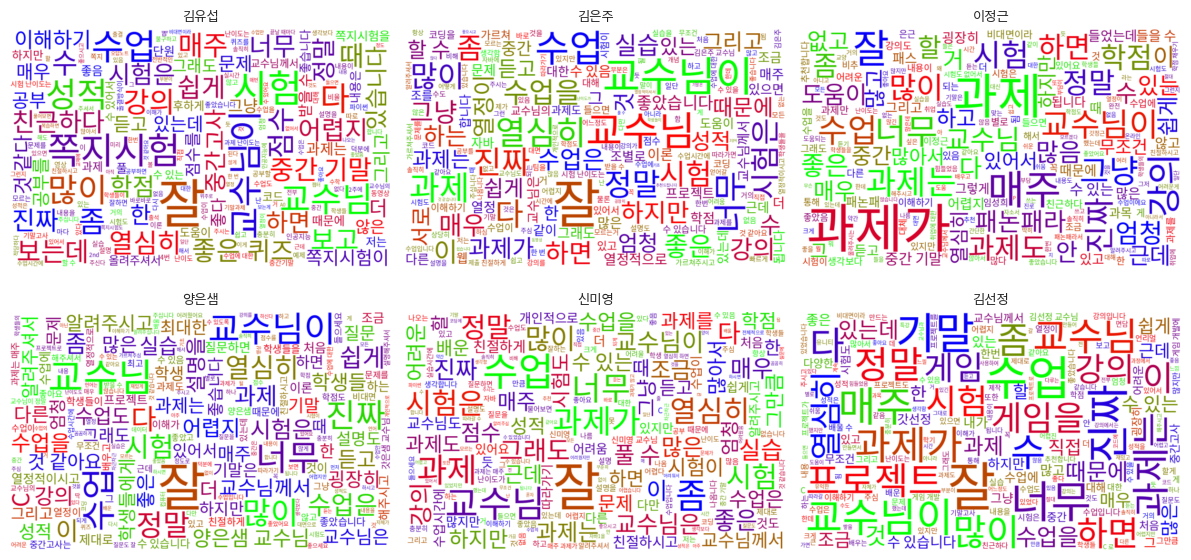

In [10]:
from wordcloud import WordCloud

plt.figure(figsize=(12, 6))

for i, professor in enumerate(professor_names):
    professor_df = df[df['professor'] == professor]
    all_reviews = ' '.join(professor_df['review'])

    all_reviews.strip()

    wordcloud = WordCloud(
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        font_path='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
        background_color='white',
        colormap='brg'
    ).generate(all_reviews)

    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(professor)

plt.tight_layout()
plt.show()

### Visualize embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


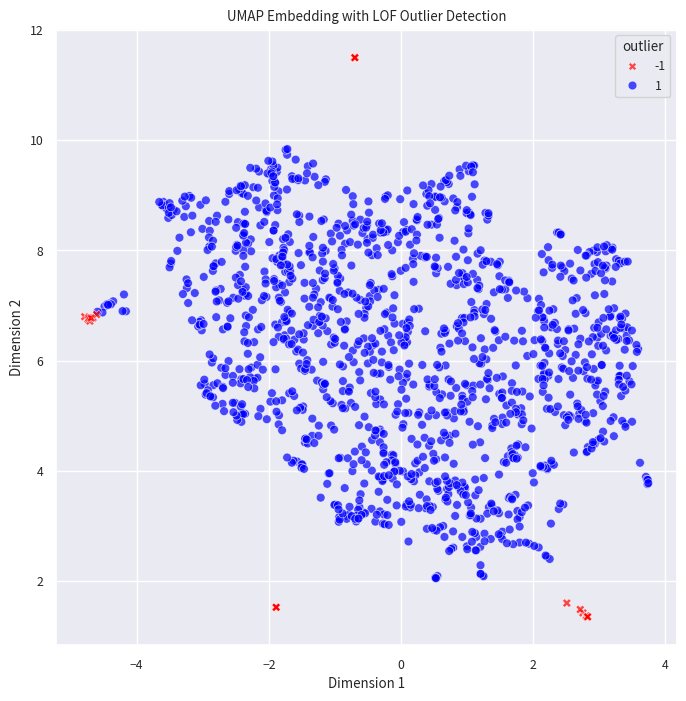

In [11]:
import umap
from sklearn.neighbors import LocalOutlierFactor

# UMAP dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=5)
embedding = umap_model.fit_transform(df['review_embedding'].tolist())

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.02)
outlier_labels = lof.fit_predict(embedding)

umap_df = pd.DataFrame(embedding, columns=['umap_dim_1', 'umap_dim_2'])
umap_df['outlier'] = outlier_labels

# Visualize
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='umap_dim_1',
    y='umap_dim_2',
    hue='outlier',
    style='outlier',
    palette={1: 'blue', -1: 'red'},
    markers={1: 'o', -1: 'X'},
    data=umap_df,
    s=40,
    alpha=0.7
)

plt.title('UMAP Embedding with LOF Outlier Detection')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.grid(True)
plt.show()

In [12]:
for i in df[np.array(outlier_labels) == -1]['review']:
    print(i)
    print('---------')

총평 : 솔직히 자바1은 다른 교수님에 비해 이 교수님께 배워야 된다고 생각함 일단 진짜 배울 수 있음 제로 베이스라도 수업 꼼꼼하게 듣고 예시문제 복습 조금만 하면 자바에 대한 기본은 확실하게 얻어갈 수 있었던 것 같음

미래의 수강자들을 위해 수업에 대한 특징을 몇 가지 말하자면, 우선 강의 내용에 대한 패턴은 같음  큰 변화가 없음 즉 족보가 돌기 상당히 쉬운 과목이고 교수님도 그 점을 인정하신 바가 있음

하지만 족보가 없는 나같은 복전생들의 경우에는 불리할 수도 있겠다고 생각했지만, 그건 또 절대 아님... 시험 문제를 어떻게 내실 것인지에 대한 유추가 상당히 쉽고 비슷한 유형의 패턴대로 진행하시기 때문에 정말 수업에 집중하고 열심히 듣는다면 A 이상 받는 것 수월함. 덧붙여 분반의 여부도 상당하 중요한데 재수강생들 많으면 A+ 다음이 B+이 될 수 있으니 그들보다 더 열심히 하길 바람

수업은 중간 기말 + 깜지(연산자 테스트/자바 전체 원맵 작성) + 출석(정말 중요하게 생각하심, 첫 날에 오티라고 안 가면 손해) + 다량의 과제(실습시간에 하는 실습태도, 개별 과제인 문제해결 등) => 이걸 개인이 아니고 조별로 진행함(랜덤)  "조별로 다 끝내야 갈 수 있다, 모두 내고 가라, 모르면 알려줘라, 서로 도와줘가며 문제 해결해라..." 가 조를 만든 목적이기에 진짜 내가 부족하다면 부담을 느낄 수 있을 것 같음(같이 못 가니까...) 하지만 조별이라 과제 물어볼 수도 있고 공유도 가능해서 그런 부분에서는 문제가 없을 것 같음

결론을 내 보자면 수업은 상당히 좋음 하지만 주변에 정보를 얻을 수가 없는 나같은 복전생들에게 조금 부담이 될 수는 있다는 것... 선행 학습이 굳이 필요가 없어서 좋지만 복습은 진짜 너무 필요하다는 것...

사실 진짜 나도 너무 외롭고 힘들었어서 모든 시험 문제의 내용과 과제 제출했던 것 교수님이 강조하신 모든 필기를 넘겨주고 싶은 마음 가득함... 모두 화이팅!
---------
자바1 한번 복습해주시고 다음껄 나가십니

# Modeling

### Prepare data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.array(df['review_embedding'].tolist())
y = df['professor']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Train SVM

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Test Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

SVM Test Accuracy: 0.4725
              precision    recall  f1-score   support

         김선정       0.75      0.29      0.41        21
         김유섭       0.53      0.59      0.56        32
         김은주       0.32      0.25      0.28        53
         신미영       0.49      0.62      0.55        56
         양은샘       0.39      0.42      0.40        64
         이정근       0.62      0.62      0.62        47

    accuracy                           0.47       273
   macro avg       0.52      0.46      0.47       273
weighted avg       0.48      0.47      0.46       273



### Train Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Test Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Random Forest Test Accuracy: 0.4139
              precision    recall  f1-score   support

         김선정       0.62      0.24      0.34        21
         김유섭       0.50      0.34      0.41        32
         김은주       0.29      0.15      0.20        53
         신미영       0.38      0.64      0.48        56
         양은샘       0.38      0.42      0.40        64
         이정근       0.53      0.55      0.54        47

    accuracy                           0.41       273
   macro avg       0.45      0.39      0.39       273
weighted avg       0.42      0.41      0.40       273



### Bayesian Optimization

In [16]:
!pip install scikit-optimize -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.8 MB/s eta 0:00:00


In [17]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

param_space = {
    'n_estimators': Integer(100, 200),
    'max_depth': Integer(10, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# n_iter: Number of optimization iterations
# cv: Number of cross-validation folds
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

print(f'Best parameters found: {bayes_search.best_params_}')

# Get the best model
best_rf_model = bayes_search.best_estimator_

# Predict
y_pred = best_rf_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Bayes Optimized Random Forest Test Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(17), np.int64(1), np.int64(10), np.int64(200)] before, using random point ['entropy', np.int64(18), np.int64(5), np.int64(8), np.int64(182)]
  warnings.warn(


Best parameters found: OrderedDict([('criterion', 'entropy'), ('max_depth', 14), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 200)])
Bayes Optimized Random Forest Test Accuracy: 0.4652
              precision    recall  f1-score   support

         김선정       0.80      0.19      0.31        21
         김유섭       0.55      0.38      0.44        32
         김은주       0.44      0.23      0.30        53
         신미영       0.43      0.73      0.54        56
         양은샘       0.40      0.48      0.44        64
         이정근       0.57      0.57      0.57        47

    accuracy                           0.47       273
   macro avg       0.53      0.43      0.43       273
weighted avg       0.49      0.47      0.45       273



### Train Neural Network

In [18]:
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define the network
class MyNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MyNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [19]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Instantiate
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = MyNN(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
num_epochs = 50
best_val_accuracy = 0.0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):

    # Training loop
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 5 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, '
            f'Training Loss: {train_loss:.4f}, '
            f'Validation Loss: {val_loss:.4f}, '
            f'Validation Accuracy: {val_accuracy:.4f}'
        )

    # Save the best model yet
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'nn_model.pth')
        print(f'New best: {best_val_accuracy:.4f}')

New best: 0.2051
New best: 0.3040
New best: 0.4212
Epoch 5/50, Training Loss: 1.4436, Validation Loss: 1.4549, Validation Accuracy: 0.4359
New best: 0.4359
New best: 0.4469
New best: 0.4542
Epoch 10/50, Training Loss: 1.1863, Validation Loss: 1.4171, Validation Accuracy: 0.4432
New best: 0.4652
New best: 0.4762
Epoch 15/50, Training Loss: 0.9776, Validation Loss: 1.4117, Validation Accuracy: 0.4469
Epoch 20/50, Training Loss: 0.8695, Validation Loss: 1.4335, Validation Accuracy: 0.4432
Epoch 25/50, Training Loss: 0.7141, Validation Loss: 1.5234, Validation Accuracy: 0.4432
Epoch 30/50, Training Loss: 0.5829, Validation Loss: 1.6493, Validation Accuracy: 0.4396
Epoch 35/50, Training Loss: 0.4327, Validation Loss: 1.8141, Validation Accuracy: 0.4249
Epoch 40/50, Training Loss: 0.3322, Validation Loss: 1.9869, Validation Accuracy: 0.4505
Epoch 45/50, Training Loss: 0.2561, Validation Loss: 2.2520, Validation Accuracy: 0.4103
Epoch 50/50, Training Loss: 0.2210, Validation Loss: 2.4309, Val

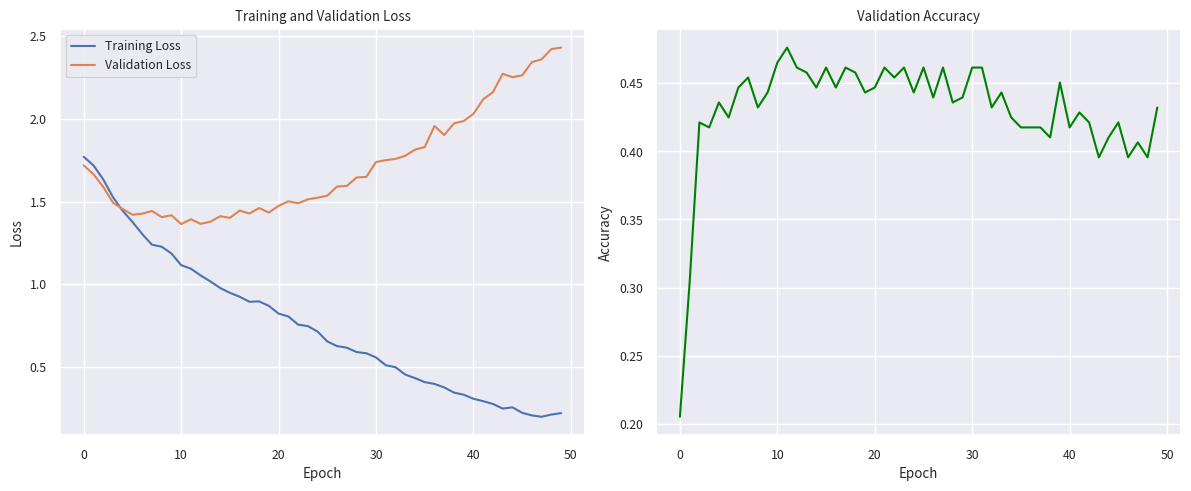

In [20]:
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Load the model state
loaded_model = MyNN(input_size, num_classes)
loaded_model.load_state_dict(torch.load('nn_model.pth'))
loaded_model.eval()

# Predict
y_pred_tensor = loaded_model(X_test_tensor)
_, y_pred = torch.max(y_pred_tensor, 1)
y_pred = y_pred.numpy()

# Evaluate
accuracy_nn = accuracy_score(y_test, y_pred)
print(f'NN Test Accuracy: {accuracy_nn:.4f}')

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

NN Test Accuracy: 0.4762
              precision    recall  f1-score   support

         김선정       0.62      0.38      0.47        21
         김유섭       0.45      0.66      0.53        32
         김은주       0.35      0.38      0.36        53
         신미영       0.46      0.57      0.51        56
         양은샘       0.51      0.38      0.43        64
         이정근       0.62      0.53      0.57        47

    accuracy                           0.48       273
   macro avg       0.50      0.48      0.48       273
weighted avg       0.49      0.48      0.47       273



### Visualize result

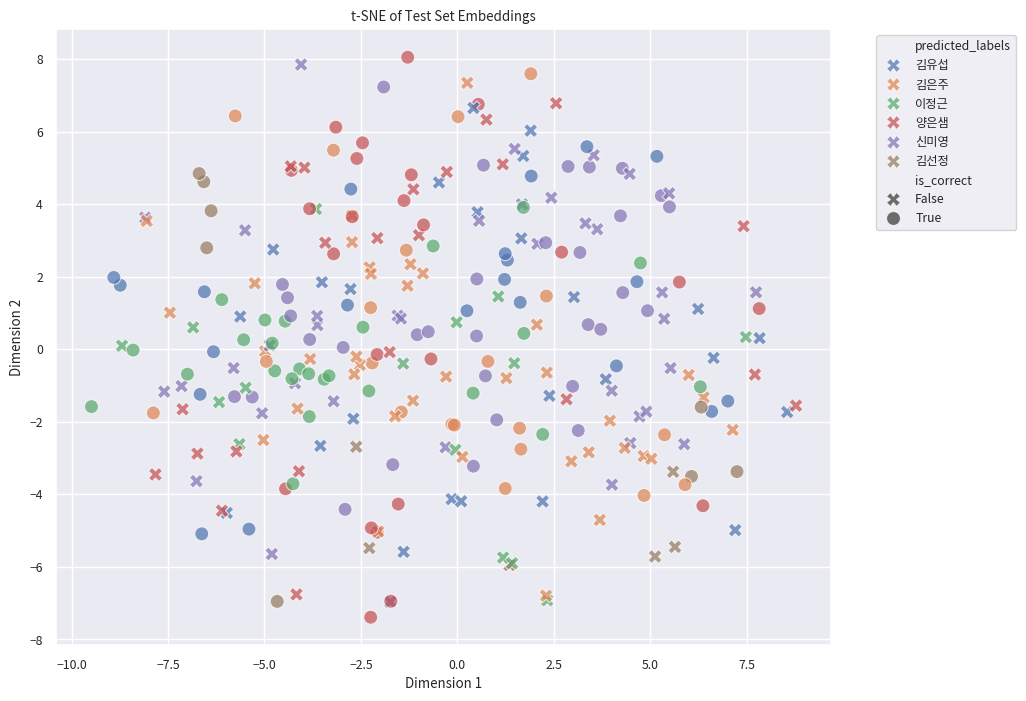

In [22]:
from sklearn.manifold import TSNE

# t-SNE dimensionality reduction
tsne_test = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test) - 1))
tsne_test_results = tsne_test.fit_transform(X_test)

tsne_test_df = pd.DataFrame(tsne_test_results, columns=['tsne_dim_1', 'tsne_dim_2'])
tsne_test_df['true_labels'] = label_encoder.inverse_transform(y_test)
tsne_test_df['predicted_labels'] = label_encoder.inverse_transform(y_pred)
tsne_test_df['is_correct'] = y_test == y_pred

# Visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_dim_1',
    y='tsne_dim_2',
    hue='predicted_labels',
    style='is_correct',
    markers={True: 'o', False: 'X'},
    data=tsne_test_df,
    s=100,
    alpha=0.7
)

plt.title('t-SNE of Test Set Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()